## Copy file

In [1]:
import os
import shutil
from tqdm import tqdm

def copy_files_with_progress(src_dir, dst_dir):
    """
    拷贝src_dir目录下的所有文件（包括子目录的文件）到dst_dir目录，并显示进度条。

    Args:
        src_dir (str): 源目录路径。
        dst_dir (str): 目标目录路径。
    """
    # 检查目标目录是否存在，不存在则创建
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    # 获取src_dir中所有文件的完整路径列表
    files_to_copy = []
    for root, _, files in os.walk(src_dir):
        for file in files:
            # 构建每个文件的完整路径
            full_file_path = os.path.join(root, file)
            files_to_copy.append(full_file_path)

    # 拷贝文件并显示进度条
    for file_path in tqdm(files_to_copy, desc="Copying files"):
        # # 计算相对路径
        # rel_path = os.path.relpath(file_path, src_dir)
        # # 目标文件的完整路径
        # dst_file_path = os.path.join(dst_dir, rel_path)
        
        # # 创建目标文件所在的目录
        # os.makedirs(os.path.dirname(dst_file_path), exist_ok=True)

        # 拷贝文件
        shutil.copy2(file_path, os.path.join(dst_dir, os.path.basename(file_path)))

# 示例用法：
# copy_files_with_progress("/path/to/source", "/path/to/destination")



In [2]:
import os

raw_dataset_dir = "/comp_robot/yangyuqin/workplace/CountingDataManage/visual_search_api/img_group_backup"
unqualified_dataset_dir = "/comp_robot/yangyuqin/workplace/CountingDataManage/visual_search_api/img_output"
data_dst_dir = "/comp_robot/yangyuqin/workplace/CountingDataManage/Classify_Unqualified_Model/data/raw"

copy_files_with_progress(raw_dataset_dir, data_dst_dir)

Copying files: 100%|██████████| 29447/29447 [08:57<00:00, 54.79it/s]


## Get unqualified file basename

In [2]:
def get_file_basename(src_dir):
    """
    得到src_dir目录下所有文件的basename列表。

    Args:
        src_dir (str): 源目录路径。
    """

    # 获取src_dir中所有文件的完整路径列表
    target_files = set()
    for _, _, files in os.walk(src_dir):
        for file in files:
            target_files.add(file)
    return target_files


In [3]:
import os

qualified_dataset_dir = "/comp_robot/yangyuqin/workplace/CountingDataManage/visual_search_api/img_output"
data_dst_dir = "/comp_robot/yangyuqin/workplace/CountingDataManage/Classify_Unqualified_Model/data/raw"
qualified_file_basename_set = get_file_basename(qualified_dataset_dir)



In [4]:
print("qualified: {}".format(len(qualified_file_basename_set) ))

qualified: 22649


## Construct the dataset for training the model

'origin_173_002.jpg'

In [5]:
import cv2
import pandas as pd
from tqdm import tqdm
dataset_df = pd.DataFrame()

sorted_data_file_list = sorted(os.listdir(data_dst_dir))
failed_files_lst = []
# 遍历目标目录的所有文件
for file in tqdm(sorted_data_file_list):
    filepath = os.path.join(data_dst_dir, file)
    try:
        img = cv2.imread(filepath)
        class_name = "Qualified"
        if file not in qualified_file_basename_set:
            class_name = "Unqualified"
        if img is not None:
            # 添加新行到 DataFrame
            new_row = pd.DataFrame({
                'Class': [class_name], 
                'file': [filepath], 
                'width': [img.shape[1]], 
                'height': [img.shape[0]]
            })
            dataset_df = pd.concat([dataset_df, new_row], ignore_index=True)
        else:
            print(f"{filepath} reading failed (image is None)")
            failed_files_lst.append(filepath)

    except Exception as e:
        print(f"{filepath} reading failed")
        print(e)
        failed_files_lst.append(filepath)
        # raise e
    

        
        


  6%|▋         | 1908/29447 [01:36<19:12, 23.90it/s]

/comp_robot/yangyuqin/workplace/CountingDataManage/Classify_Unqualified_Model/data/raw/origin_172_059.jpg reading failed (image is None)


 87%|████████▋ | 25710/29447 [21:48<02:43, 22.86it/s]

/comp_robot/yangyuqin/workplace/CountingDataManage/Classify_Unqualified_Model/data/raw/origin_789_045.jpg reading failed (image is None)


100%|██████████| 29447/29447 [25:07<00:00, 19.53it/s]


In [14]:
failed_files_lst

[]

In [9]:
# save to parquet 
dataset_df.to_parquet('../../dataset/spider_img/parquet/dataset.parquet')


In [1]:
import pandas as pd
dataset_df = pd.read_parquet('../../dataset/spider_img/parquet/dataset.parquet')

In [2]:
dataset_df

,Class,file,width,height
0,Qualified,/comp_robot/yangyuqin/workplace/CountingDataMa...,1024,683
1,Qualified,/comp_robot/yangyuqin/workplace/CountingDataMa...,1024,683
2,Qualified,/comp_robot/yangyuqin/workplace/CountingDataMa...,1024,768
3,Qualified,/comp_robot/yangyuqin/workplace/CountingDataMa...,768,1024
4,Qualified,/comp_robot/yangyuqin/workplace/CountingDataMa...,768,576
...,...,...,...,...
29440,Qualified,/comp_robot/yangyuqin/workplace/CountingDataMa...,900,1200
29441,Qualified,/comp_robot/yangyuqin/workplace/CountingDataMa...,500,375
29442,Qualified,/comp_robot/yangyuqin/workplace/CountingDataMa...,1045,1200
29443,Qualified,/comp_robot/yangyuqin/workplace/CountingDataMa...,800,533


## 可视化图像宽度和高度分布

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def visualize_image_size_distribution(df, width_col='width', height_col='height', output_file=None):
    """
    可视化图像尺寸的分布情况，输出为一个文件。

    Args:
        df (pd.DataFrame): 包含图像宽度和高度的数据框。
        width_col (str): DataFrame中表示图像宽度的列名。
        height_col (str): DataFrame中表示图像高度的列名。
        output_file (str): 保存输出图像的文件路径。
    """
    x = df[width_col]
    y = df[height_col]
    
    # 计算密度
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # 按密度排序，使得密集点最后绘制
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # 绘制散点图
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, c=z, s=5, cmap='Spectral_r')

    # 设置刻度大小
    plt.tick_params(labelsize=15)

    # 设置x、y轴范围
    xy_max = max(max(df[width_col]), max(df[height_col]))
    plt.xlim(xmin=0, xmax=xy_max)
    plt.ylim(ymin=0, ymax=xy_max)

    # 设置坐标轴标签
    plt.ylabel('Height', fontsize=12)
    plt.xlabel('Width', fontsize=12)


    # 保存图像为PDF
    if output_file is not None:
        plt.savefig(output_file, dpi=120, bbox_inches='tight')
    plt.show()

# 示例调用
# visualize_image_size_distribution(dataset_df, width_col='width', height_col='height', output_file='图像尺寸分布.pdf')


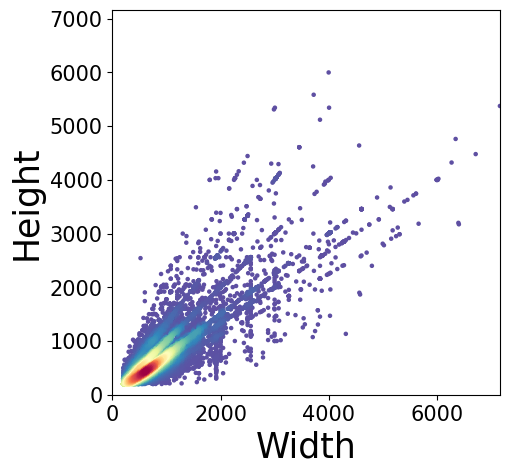

In [12]:
visualize_image_size_distribution(dataset_df, width_col='width', height_col='height')

## Dataloader

### pt dataset

In [1]:
import os
import torch
import random
import cv2
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms

def custom_collate_fn(batch):
    """
    自定义collate_fn，用于过滤掉返回None的样本。
    
    Args:
        batch: 一个批次的数据，其中可能包含 (img_tensor, label) 的形式，也可能包含 None。
    
    Returns:
        Valid images and labels as tensors.
    """
    # 过滤掉 None 的样本
    batch = [item for item in batch if item[0] is not None]
    
    if len(batch) == 0:
        # 如果没有有效的样本，则返回空的张量
        return torch.empty(0), torch.empty(0)

    # 分别提取图像和标签
    images, labels = zip(*batch)

    # 将图像堆叠为一个批次
    images = torch.stack(images)
    # 将标签也转换为张量
    labels = torch.tensor(labels)

    return images, labels

# 假设 train_dataset 已经加载并包含了 'image' 和 'label' 两列
def balance_dataset(dataset, class_column='label'):
    """
    通过下采样来平衡数据集中的类别比例
    Args:
        dataset: 需要平衡的原始数据集
        class_column: 表示类别标签的列名（默认 'label'）
    
    Returns:
        一个新的平衡数据集
    """
    # 获取所有类别
    class_0 = [i for i, sample in enumerate(dataset) if sample[1] == 0]
    class_1 = [i for i, sample in enumerate(dataset) if sample[1] == 1]

    # 获取较小类的数量
    min_class_count = min(len(class_0), len(class_1))

    # 对较大类进行下采样
    class_0_sampled = random.sample(class_0, min_class_count)
    class_1_sampled = random.sample(class_1, min_class_count)

    # 将下采样后的索引组合起来
    balanced_indices = class_0_sampled + class_1_sampled

    # 重新洗牌以打乱顺序
    random.shuffle(balanced_indices)

    # 根据新的索引创建平衡后的数据集
    balanced_dataset = torch.utils.data.Subset(dataset, balanced_indices)
    
    return balanced_dataset


# 加载保存的训练集和测试集
train_dataset = torch.load('../../dataset/spider_img/dataloader/train_dataset.pt')
test_dataset = torch.load('../../dataset/spider_img/dataloader/test_dataset.pt')

# 对训练集进行平衡处理
balanced_train_dataset = balance_dataset(train_dataset)





/comp_robot/yangyuqin/Anaconda3/envs/deepl2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 创建数据加载器
train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 定义训练函数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        # 计算损失和准确率
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

# 定义测试函数
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 计算损失和准确率
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    accuracy = correct / total
    print(f"Test Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

In [4]:
!nvidia-smi


Wed Sep 18 17:59:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:4F:00.0 Off |                  N/A |
| 30%   26C    P8              34W / 350W |  11239MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# 检查是否有GPU可用
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# # 加载预训练的 ResNet18 模型，并进行微调
# model = models.resnet18(pretrained=True)
# 加载预训练的 ResNet50 模型
model = models.resnet50(pretrained=True)
# # 加载预训练的 VGG16 模型
# model = models.vgg16(pretrained=True)
# # 加载预训练的 DenseNet121 模型
# model = models.densenet121(pretrained=True)
# # 加载预训练的 MobileNetV2 模型
# model = models.mobilenet_v2(pretrained=True)


In [6]:
# 替换最后一层，以适应二分类任务
num_ftrs = model.fc.in_features  # 获取 ResNet50 全连接层的输入特征数
model.fc = nn.Linear(num_ftrs, 2)  # 将最后一层替换为适合二分类任务的线性层

# 将模型移到设备（GPU或CPU）
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数（用于分类任务）
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

# 开始训练
num_epochs = 1000
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    train(model, train_loader, criterion, optimizer, device)
    test(model, test_loader, criterion, device)

Epoch 1/10:


100%|██████████| 170/170 [00:46<00:00,  3.66it/s]


Train Loss: 0.7061, Accuracy: 0.5961


100%|██████████| 93/93 [00:10<00:00,  8.65it/s]


Test Loss: 0.6091, Accuracy: 0.6490
Epoch 2/10:


100%|██████████| 170/170 [00:46<00:00,  3.66it/s]


Train Loss: 0.6452, Accuracy: 0.6292


100%|██████████| 93/93 [00:10<00:00,  8.76it/s]


Test Loss: 0.6190, Accuracy: 0.6273
Epoch 3/10:


100%|██████████| 170/170 [00:46<00:00,  3.63it/s]


Train Loss: 0.6093, Accuracy: 0.6691


100%|██████████| 93/93 [00:10<00:00,  8.75it/s]


Test Loss: 0.5916, Accuracy: 0.6634
Epoch 4/10:


100%|██████████| 170/170 [00:46<00:00,  3.62it/s]


Train Loss: 0.5945, Accuracy: 0.6815


100%|██████████| 93/93 [00:10<00:00,  8.78it/s]


Test Loss: 0.6578, Accuracy: 0.5753
Epoch 5/10:


100%|██████████| 170/170 [00:46<00:00,  3.68it/s]


Train Loss: 0.5783, Accuracy: 0.6902


100%|██████████| 93/93 [00:11<00:00,  7.91it/s]


Test Loss: 0.6066, Accuracy: 0.6753
Epoch 6/10:


100%|██████████| 170/170 [00:47<00:00,  3.55it/s]


Train Loss: 0.5733, Accuracy: 0.7028


100%|██████████| 93/93 [00:12<00:00,  7.74it/s]


Test Loss: 0.6282, Accuracy: 0.6339
Epoch 7/10:


100%|██████████| 170/170 [00:46<00:00,  3.68it/s]


Train Loss: 0.5569, Accuracy: 0.7107


100%|██████████| 93/93 [00:12<00:00,  7.59it/s]


Test Loss: 0.5498, Accuracy: 0.7039
Epoch 8/10:


100%|██████████| 170/170 [00:46<00:00,  3.64it/s]


Train Loss: 0.5408, Accuracy: 0.7214


100%|██████████| 93/93 [00:11<00:00,  8.29it/s]


Test Loss: 0.8428, Accuracy: 0.5031
Epoch 9/10:


100%|██████████| 170/170 [00:46<00:00,  3.66it/s]


Train Loss: 0.5295, Accuracy: 0.7322


100%|██████████| 93/93 [00:11<00:00,  8.25it/s]


Test Loss: 0.6226, Accuracy: 0.6947
Epoch 10/10:


100%|██████████| 170/170 [00:46<00:00,  3.63it/s]


Train Loss: 0.5224, Accuracy: 0.7390


100%|██████████| 93/93 [00:10<00:00,  8.48it/s]

Test Loss: 0.7453, Accuracy: 0.5361


# Draft

###  Yang dataset

In [7]:
import os
import torch
import cv2
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# 假设你已经有了dataset_df，下面是数据预处理和加载的代码
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # 假设所有图像都需要调整到28x28的尺寸
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])




In [8]:
# 准备存储图像和标签的列表
images = []
labels = []

# 遍历dataset_df，读取图像并应用预处理
for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df)):
    img_path = row['file']
    label = 1 if row['Class'] == 'Qualified' else 0  # 假设你用1表示Qualified, 0表示Unqualified
    
    try:
        img = cv2.imread(img_path)
        if img is not None:
            # 处理并添加到列表
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 转换为RGB
            img_tensor = transform(img)
            images.append(img_tensor)
            labels.append(label)
        else:
            print(f"Image at {img_path} is None, skipping.")
    except Exception as e:
        print(f"Error reading image at {img_path}: {e}")



100%|██████████| 29445/29445 [31:46<00:00, 15.44it/s]


In [9]:
# 将图像和标签转换为PyTorch张量
images_tensor = torch.stack(images)  # 将图像堆叠为4D张量 (N, C, H, W)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# 创建数据集
dataset = TensorDataset(images_tensor, labels_tensor)

# 分割训练集和测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 打印一些信息来验证
print("Train DataLoader:", len(train_loader))
print("Test DataLoader:", len(test_loader))

Train DataLoader: 369
Test DataLoader: 93


# save pt dataloader to disk

In [10]:

# 保存训练集和测试集
torch.save(train_dataset, '../../dataset/spider_img/dataloader/train_dataset.pt')
torch.save(test_dataset, '../../dataset/spider_img/dataloader/test_dataset.pt')


# Another dataset method

In [1]:
# read df
import pandas as pd
dataset_df = pd.read_parquet('../../dataset/spider_img/parquet/dataset.parquet')

In [ ]:
dataset_df

In [2]:
import os
import torch
import cv2
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from dataset import YangDataset
# 假设你已经有了dataset_df，下面是数据预处理和加载的代码
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # 假设所有图像都需要调整到28x28的尺寸
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset=YangDataset(dataset_df,transform)




/comp_robot/yangyuqin/Anaconda3/envs/deepl2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 分割训练集和测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])



In [5]:
print(f"Train len:{len(train_dataset)}\tTest len:{len(test_dataset)}")

Train len:23556	Test len:5889


In [6]:
def custom_collate_fn(batch):
    """
    自定义collate_fn，用于过滤掉返回None的样本。
    
    Args:
        batch: 一个批次的数据，其中可能包含 (img_tensor, label) 的形式，也可能包含 None。
    
    Returns:
        Valid images and labels as tensors.
    """
    # 过滤掉 None 的样本
    batch = [item for item in batch if item[0] is not None]
    
    if len(batch) == 0:
        # 如果没有有效的样本，则返回空的张量
        return torch.empty(0), torch.empty(0)

    # 分别提取图像和标签
    images, labels = zip(*batch)

    # 将图像堆叠为一个批次
    images = torch.stack(images)
    # 将标签也转换为张量
    labels = torch.tensor(labels)

    return images, labels

In [7]:
# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 定义训练函数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        # 计算损失和准确率
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

# 定义测试函数
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 计算损失和准确率
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    accuracy = correct / total
    print(f"Test Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

In [ ]:
# 检查是否有GPU可用
# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:2")


# 加载预训练的 ResNet50 模型
model_resnet50 = models.resnet50(pretrained=True)
# # 加载预训练的 VGG16 模型
# model_vgg16 = models.vgg16(pretrained=True)
# # 加载预训练的 DenseNet121 模型
# model_densenet121 = models.densenet121(pretrained=True)
# # 加载预训练的 MobileNetV2 模型
# model_mobilenet_v2 = models.mobilenet_v2(pretrained=True)
# 替换最后一层，以适应当前任务（假设二分类任务）
num_ftrs = models.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 二分类：‘Qualified’和‘Unqualified’

# 将模型移到设备（GPU或CPU）
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数（用于分类任务）
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

In [10]:
# 开始训练
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    train(model, train_loader, criterion, optimizer, device)
    test(model, test_loader, criterion, device)

Epoch 1/10:


100%|██████████| 369/369 [23:26<00:00,  3.81s/it]


Train Loss: 0.5048, Accuracy: 0.7748


100%|██████████| 93/93 [05:36<00:00,  3.61s/it]


Test Loss: 0.4906, Accuracy: 0.7567
Epoch 2/10:


 48%|████▊     | 176/369 [10:15<05:53,  1.83s/it] Corrupt JPEG data: bad Huffman code
Premature end of JPEG file
100%|██████████| 369/369 [22:04<00:00,  3.59s/it]


Train Loss: 0.4592, Accuracy: 0.7880


100%|██████████| 93/93 [02:31<00:00,  1.63s/it]


Test Loss: 0.4660, Accuracy: 0.7930
Epoch 3/10:


100%|██████████| 369/369 [07:00<00:00,  1.14s/it]


Train Loss: 0.4369, Accuracy: 0.7972


100%|██████████| 93/93 [01:06<00:00,  1.40it/s]


Test Loss: 0.6184, Accuracy: 0.7906
Epoch 4/10:


100%|██████████| 369/369 [06:15<00:00,  1.02s/it]


Train Loss: 0.4320, Accuracy: 0.7998


100%|██████████| 93/93 [02:50<00:00,  1.84s/it]


Test Loss: 0.4217, Accuracy: 0.7972
Epoch 5/10:


  9%|▉         | 33/369 [00:24<02:16,  2.47it/s]libpng warning: Incorrect sBIT chunk length
Premature end of JPEG file
libpng warning: Incorrect sBIT chunk length
100%|██████████| 369/369 [06:11<00:00,  1.01s/it]


Train Loss: 0.4163, Accuracy: 0.8082


100%|██████████| 93/93 [02:15<00:00,  1.46s/it]


Test Loss: 0.4326, Accuracy: 0.7966
Epoch 6/10:


100%|██████████| 369/369 [16:54<00:00,  2.75s/it]


Train Loss: 0.4127, Accuracy: 0.8099


100%|██████████| 93/93 [04:32<00:00,  2.93s/it]


Test Loss: 0.5009, Accuracy: 0.7514
Epoch 7/10:


 27%|██▋       | 99/369 [03:30<25:18,  5.62s/it]  Premature end of JPEG file
Corrupt JPEG data: bad Huffman code
100%|██████████| 369/369 [16:14<00:00,  2.64s/it]


Train Loss: 0.3927, Accuracy: 0.8186


100%|██████████| 93/93 [03:06<00:00,  2.00s/it]


Test Loss: 0.4289, Accuracy: 0.7908
Epoch 8/10:


 76%|███████▌  | 279/369 [4:17:31<1:23:04, 55.38s/it]


KeyboardInterrupt: 

In [21]:
model_path = "/comp_robot/yangyuqin/workplace/startup/result/spider_img/model/model_20240911.pth"
torch.save(model.state_dict(), model_path)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 重新创建模型结构
model = models.resnet18(pretrained=True)
model_path = "/comp_robot/yangyuqin/workplace/startup/result/spider_img/model/model_20240911.pth"
model.load_state_dict(torch.load(model_path))
model.eval()  # 切换为评估模式

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 512]) from checkpoint, the shape in current model is torch.Size([1000, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1000]).

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, recall_score

# 模型预测函数
def get_predictions(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            # 模型前向传播
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

# 计算召回率和混淆矩阵
def evaluate_model(model, data_loader, device, class_names):
    # 获取预测值和真实标签
    preds, labels = get_predictions(model, data_loader, device)
    
    # 打印分类报告，包含每个类别的precision, recall, f1-score
    print("Classification Report:")
    print(classification_report(labels, preds, target_names=class_names))
    
    # 计算混淆矩阵
    conf_matrix = confusion_matrix(labels, preds)
    
    # 绘制混淆矩阵
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()




ImportError: cannot import name 'murmurhash3_32' from 'sklearn.utils.murmurhash' (unknown location)

In [ ]:
# 假设你有类别名称列表
class_names = ['Unqualified', 'Qualified']  # 替换为你的实际类别名称

# 假设你已经有一个data_loader和训练好的model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 调用评估函数
evaluate_model(model, test_loader, device, class_names)